In [41]:
import pandas as pd

# Load data
student_housing = pd.read_csv('student_housing.csv')
property_2024 = pd.read_csv('property_assessment_2024.csv')

# Set the years you want to check
years = list(range(2016, 2025))

# Loop through each year
for year in years:
    print(f"\n--- Columns for year {year} ---")
    
    # Define the path
    path = f'property_assessment_{year}.csv'  # <-- make sure filename pattern matches your files
    
    try:
        # Load just a few rows to check columns
        df = pd.read_csv(path, nrows=5)
        
        # Print all column names
        print(df.columns.tolist())
        
    except Exception as e:
        print(f"Could not load file for year {year}. Error: {e}")



/var/folders/h7/4njx58kj1q3fjd0lhgg72pq80000gn/T/ipykernel_95843/2409078534.py:4: DtypeWarning: Columns (4,7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  student_housing = pd.read_csv('student_housing.csv')
/var/folders/h7/4njx58kj1q3fjd0lhgg72pq80000gn/T/ipykernel_95843/2409078534.py:5: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  property_2024 = pd.read_csv('property_assessment_2024.csv')



--- Columns for year 2016 ---
['PID', 'CM_ID', 'GIS_ID', 'ST_NUM', 'ST_NAME', 'ST_NAME_SUF', 'UNIT_NUM', 'ZIPCODE', 'PTYPE', 'LU', 'OWN_OCC', 'OWNER', 'MAIL_ADDRESSEE', 'MAIL_ADDRESS', 'MAIL CS', 'MAIL_ZIPCODE', 'AV_LAND', 'AV_BLDG', 'AV_TOTAL', 'GROSS_TAX', 'LAND_SF', 'YR_BUILT', 'YR_REMOD', 'GROSS_AREA', 'LIVING_AREA', 'NUM_FLOORS', 'STRUCTURE_CLASS', 'R_BLDG_STYL', 'R_ROOF_TYP', 'R_EXT_FIN', 'R_TOTAL_RMS', 'R_BDRMS', 'R_FULL_BTH', 'R_HALF_BTH', 'R_BTH_STYLE', 'R_BTH_STYLE2', 'R_BTH_STYLE3', 'R_KITCH', 'R_KITCH_STYLE', 'R_KITCH_STYLE2', 'R_KITCH_STYLE3', 'R_HEAT_TYP', 'R_AC', 'R_FPLACE', 'R_EXT_CND', 'R_OVRALL_CND', 'R_INT_CND', 'R_INT_FIN', 'R_VIEW', 'S_NUM_BLDG', 'S_BLDG_STYL', 'S_UNIT_RES', 'S_UNIT_COM', 'S_UNIT_RC', 'S_EXT_FIN', 'S_EXT_CND', 'U_BASE_FLOOR', 'U_NUM_PARK', 'U_CORNER', 'U_ORIENT', 'U_TOT_RMS', 'U_BDRMS', 'U_FULL_BTH', 'U_HALF_BTH', 'U_BTH_STYLE', 'U_BTH_STYLE2', 'U_BTH_STYLE3', 'U_KITCH_TYPE', 'U_KITCH_STYLE', 'U_HEAT_TYP', 'U_AC', 'U_FPLACE', 'U_INT_FIN', 'U_INT_C

In [42]:
# Clean Student Housing
student_housing['StreetNumber'] = student_housing['6a. street #'].astype(str).str.strip()
student_housing['StreetNameOnly'] = student_housing['6b. street name'].astype(str).str.strip()
student_housing['Zip'] = student_housing['6e. zip'].astype(str).str.zfill(5)


In [45]:
# --- Store results ---
year_list = []
average_list = []
median_list = []

# --- Loop over each year ---
for year in range(2016, 2025):
    print(f"Processing year {year}...")
    
    path = f'property_assessment_{year}.csv'
    
    try:
        property_data = pd.read_csv(path)
    except Exception as e:
        print(f"Error loading {year}: {e}")
        continue
    
    # --- Clean Property Data ---
    # Street Number cleaning
    property_data['ST_NUM'] = property_data['ST_NUM'].fillna('0').astype(str).str.strip()
    property_data['ST_NUM'] = property_data['ST_NUM'].str.split().str[0]
    property_data['ST_NUM'] = property_data['ST_NUM'].str.split('-').str[0]
    property_data['ST_NUM'] = property_data['ST_NUM'].str.extract(r'(\d+)')[0]
    property_data['ST_NUM'] = property_data['ST_NUM'].fillna('0')
    property_data['StreetNumber'] = property_data['ST_NUM'].astype(int).astype(str).str.strip()

    # Street Name cleaning
    property_data['StreetName'] = property_data['ST_NAME'].astype(str).str.strip().str.upper()
    property_data['StreetName'] = property_data['StreetName'].str.split().str[0]
    
    # ZIP Code selection
    if year <= 2022:
        zip_col = 'ZIPCODE'
    else:
        zip_col = 'ZIP_CODE'
    
    if zip_col not in property_data.columns:
        print(f"No ZIP column found for {year}. Skipping...")
        continue

    # Clean the ZIP codes properly
    property_data[zip_col] = property_data[zip_col].astype(str)
    property_data[zip_col] = property_data[zip_col].str.extract(r'(\d+)')[0]
    property_data[zip_col] = property_data[zip_col].fillna('00000')
    property_data['Zip'] = property_data[zip_col].str.zfill(5)

    # Value Column selection
    if year <= 2020:
        value_col = 'AV_TOTAL'
    else:
        value_col = 'TOTAL_VALUE'

    if value_col not in property_data.columns:
        print(f"No value column found for {year}. Skipping...")
        continue

    # --- Merge with Student Housing ---
    merged = pd.merge(student_housing, property_data,
                      left_on=['StreetNumber', 'StreetNameOnly', 'Zip'],
                      right_on=['StreetNumber', 'StreetName', 'Zip'],
                      how='inner')
    
    if merged.empty:
        print(f"No matches for year {year}.")
        continue

    # --- Clean Value Column ---
    merged[value_col] = (
        merged[value_col]
        .astype(str)
        .str.replace(',', '', regex=False)
        .str.replace('$', '', regex=False)
        .str.strip()
        .astype(float)
    )


    # --- Calculate Average and Median ---
    average_value = merged[value_col].mean()
    median_value = merged[value_col].median()

    year_list.append(year)
    average_list.append(average_value)
    median_list.append(median_value)

print("✅ Finished processing all years.")


Processing year 2016...


/var/folders/h7/4njx58kj1q3fjd0lhgg72pq80000gn/T/ipykernel_95843/989818353.py:13: DtypeWarning: Columns (60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  property_data = pd.read_csv(path)


Processing year 2017...


/var/folders/h7/4njx58kj1q3fjd0lhgg72pq80000gn/T/ipykernel_95843/989818353.py:13: DtypeWarning: Columns (60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  property_data = pd.read_csv(path)


Processing year 2018...


/var/folders/h7/4njx58kj1q3fjd0lhgg72pq80000gn/T/ipykernel_95843/989818353.py:13: DtypeWarning: Columns (15,60,63) have mixed types. Specify dtype option on import or set low_memory=False.
  property_data = pd.read_csv(path)


Processing year 2019...


/var/folders/h7/4njx58kj1q3fjd0lhgg72pq80000gn/T/ipykernel_95843/989818353.py:13: DtypeWarning: Columns (15,60) have mixed types. Specify dtype option on import or set low_memory=False.
  property_data = pd.read_csv(path)


Processing year 2020...


/var/folders/h7/4njx58kj1q3fjd0lhgg72pq80000gn/T/ipykernel_95843/989818353.py:13: DtypeWarning: Columns (6,15,27,28,29,34,35,36,37,38,39,40,41,42,44,45,46,47,48,58,59,64,65,66,67,68,69,70,72,73,74) have mixed types. Specify dtype option on import or set low_memory=False.
  property_data = pd.read_csv(path)


Processing year 2021...
Processing year 2022...
Processing year 2023...
Processing year 2024...


/var/folders/h7/4njx58kj1q3fjd0lhgg72pq80000gn/T/ipykernel_95843/989818353.py:13: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  property_data = pd.read_csv(path)


✅ Finished processing all years.


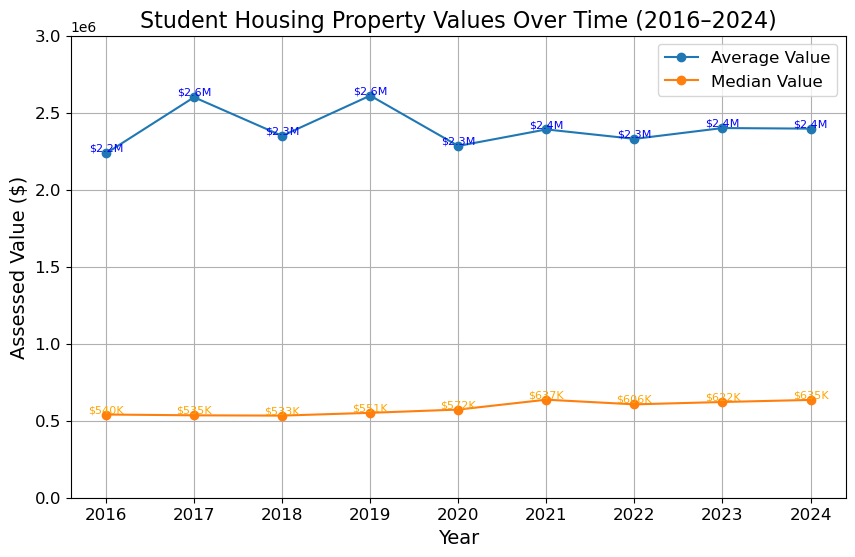

<Figure size 640x480 with 0 Axes>

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

# Plot lines
plt.plot(year_list, average_list, marker='o', label='Average Value')
plt.plot(year_list, median_list, marker='o', label='Median Value')

# Add value labels
for x, y in zip(year_list, average_list):
    plt.text(x, y, f'${y/1e6:.1f}M', ha='center', va='bottom', fontsize=8, color='blue')

for x, y in zip(year_list, median_list):
    plt.text(x, y, f'${y/1e3:.0f}K', ha='center', va='bottom', fontsize=8, color='orange')

# Labels and title
plt.xlabel('Year', fontsize=14)
plt.ylabel('Assessed Value ($)', fontsize=14)
plt.title('Student Housing Property Values Over Time (2016–2024)', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True)
plt.ylim(0, 3000000)  # Adjust y-axis limit

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show plot
plt.show()

plt.savefig('student_housing_property_trends.png', dpi=300, bbox_inches='tight')

